# **Coding and analysis tasks**

For practice, you will perform image classification on a hyperspectral image, and assign a class label (land cover) to each pixel. 

The image file (“data.tif”) is a hyperspectral airborne image acquired on November 17, 2008 by AISA-Eagle (AE) Hyperspectral Imager of CALMIT (Center for Advanced Land Management Information Technologies), University of Nebraska-Lincoln. The image covers part of the coast near Corpus Christi, Texas. It includes 63 narrow bands in the Visible and Near Infrared (VNIR) spectral range from 400 to 970 nm wavelength at a spatial resolution of 1 and 2 meters. The pixel value of each band is the surface reflectance multiplied by 10000.

The “training.csv” includes training data, each record has 65 attributes, including surface reflectance values (multiplied by 10000) of the 63 bands, land cover class (1 for Construction, 2 for Dock, 3 for Water, 4 for Building roof, 5 for Grass, 6 for Wetland), and classlabel. In this context, a classifier is a model that predicts land cover class from the surface reflectance values of those 63 bands. 

Perform and document the following tasks in your notebook:
*	Use training.csv to train different classifiers you have learned above, evaluate the performance of each classifier, and discuss the difference of the classification performance. 
* Use k-fold cross validation method to tune the hyperparameter ‘k’ for the k nearest neighbor classifier, use GridSearchCV to tune the hyperparameters of ‘max_depth’ and ‘min_sample_leaf’ for the decision tree method, plot the classification measure (you choose a proper metric, such as kappa coefficient) varied with different hyperparameters for both training set and test set. 
* Use your trained model and best hyperparameter to classify the whole image (data.tif), which means that you need to assign a class label to each pixel. Plot the original image and the classification results of different classifiers. 


Tips:

* Consider to write a function to print out different performance metrics given test data.
* Use following codes as reference to read the image data and apply the classifier to the image

```
# import package
import skimage.io as io

# read image as a numpy array
img_ds = io.imread("your image data path")
img = np.array(img_ds, dtype='uint16')  

# unroll the image
new_shape = (img.shape[0] * img.shape[1], img.shape[2]) 
img_as_array = img[:, :, :].reshape(new_shape)


# predict the class
class_pred = yourmodel.predict (img_as_array)
```



Import Packages

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, \
    precision_recall_curve, roc_auc_score, roc_curve, make_scorer, cohen_kappa_score, average_precision_score, make_scorer, log_loss
from sklearn.pipeline import Pipeline

import skimage.io as io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change your workdirectory and list the files
%cd /content/drive/My Drive/Rosemary
%ls


[Errno 2] No such file or directory: '/content/drive/My Drive/Rosemary'
/content
drive/  sample_data/


Reshape Image

In [6]:
# read image as a numpy array
img_ds = io.imread("/content/drive/My Drive/lab3 2/data.tif")
img = np.array(img_ds, dtype='uint16')  
print(f"Shape of image is: {img.shape}")

Shape of image is: (544, 544, 63)


In [7]:
# unroll the image
new_shape = (img.shape[0] * img.shape[1], img.shape[2]) 
img_as_array = img[:, :, :].reshape(new_shape)

print(f"Shape of image is: {img_as_array.shape}")

assert img_as_array.shape == new_shape

Shape of image is: (295936, 63)


In [8]:
img[0, :5, 0]

array([65367, 65308, 65351, 65348, 65348], dtype=uint16)

In [9]:
img_as_array[:5, 0].reshape(-1, 1)

array([[65367],
       [65308],
       [65351],
       [65348],
       [65348]], dtype=uint16)

Loading the training set

In [11]:
# Read training data
training = pd.read_csv("/content/drive/My Drive/lab3 2/training.csv", sep=",")

print(f"Shape of training data is: {training.shape}")
training.head()

Shape of training data is: (19357, 65)


,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,...,Band_56,Band_57,Band_58,Band_59,Band_60,Band_61,Band_62,Band_63,class,classlabel
0,293,349,383,444,454,495,541,586,613,649,...,1516,1658,2357,2301,2231,1906,1854,1881,1,Construction
1,406,462,500,538,558,627,694,741,780,829,...,1800,1935,2709,2476,2393,2110,2157,2170,1,Construction
2,726,713,763,803,845,926,1010,1096,1149,1207,...,2407,2491,2951,3078,2830,2579,2552,2647,1,Construction
3,720,765,829,877,923,1028,1126,1209,1273,1332,...,2754,2929,3361,3287,3100,2960,3052,2980,1,Construction
4,710,804,881,919,967,1090,1190,1259,1324,1394,...,3152,3280,3659,3551,3522,3327,3321,3374,1,Construction


In [12]:
training.describe()

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,...,Band_55,Band_56,Band_57,Band_58,Band_59,Band_60,Band_61,Band_62,Band_63,class
count,19357.000000,19357.000000,19357.000000,19357.000000,19357.000000,19357.000000,19357.000000,19357.000000,19357.000000,19357.00000,...,19357.000000,19357.000000,19357.000000,19357.000000,19357.000000,19357.000000,19357.000000,19357.000000,19357.000000,19357.000000
mean,141.041535,269.595340,363.131012,424.842796,450.018960,493.724751,523.165418,552.706824,564.674795,582.42176,...,1901.408948,1952.002325,1998.527768,2215.647518,2245.883763,2246.117580,2184.166400,2177.650152,2242.622204,4.350261
std,731.819759,757.762277,700.486580,647.621751,636.706727,682.586021,675.017890,654.910077,607.652320,587.91301,...,1560.537445,1569.998892,1577.510412,1380.965286,1461.337250,1478.643517,1551.562914,1595.657155,1650.479128,1.729532
min,-270.000000,-102.000000,31.000000,113.000000,145.000000,161.000000,166.000000,184.000000,194.000000,201.00000,...,233.000000,257.000000,287.000000,475.000000,408.000000,438.000000,404.000000,391.000000,390.000000,1.000000
25%,-142.000000,-15.000000,93.000000,164.000000,184.000000,200.000000,213.000000,236.000000,252.000000,270.00000,...,341.000000,385.000000,437.000000,887.000000,838.000000,835.000000,703.000000,659.000000,671.000000,3.000000
50%,-74.000000,54.000000,165.000000,241.000000,269.000000,299.000000,325.000000,354.000000,372.000000,390.00000,...,1719.000000,1770.000000,1817.000000,2069.000000,2085.000000,2074.000000,1987.000000,1969.000000,2032.000000,5.000000
75%,20.000000,137.000000,242.000000,314.000000,341.000000,376.000000,409.000000,444.000000,468.000000,491.00000,...,2441.000000,2511.000000,2566.000000,2788.000000,2849.000000,2838.000000,2774.000000,2770.000000,2848.000000,6.000000
max,4866.000000,5230.000000,4917.000000,4594.000000,4480.000000,4726.000000,4011.000000,3536.000000,3062.000000,2833.00000,...,7171.000000,7188.000000,7368.000000,6727.000000,7045.000000,7232.000000,7411.000000,7631.000000,7921.000000,6.000000


In [13]:
training[['class', 'classlabel']].apply(lambda x: (x['class'], x['classlabel']), axis=1).unique()

array([(1, 'Construction'), (2, 'Dock'), (5, 'Grass'), (4, 'Roof'),
       (3, 'Water'), (6, 'Wetland')], dtype=object)

Checking for Null Values

In [14]:
null_series = training.isnull().sum()
null_series[null_series > 0]

Series([], dtype: int64)

In [15]:
df = training.copy()

class_labels = df.pop('classlabel')
y = df.pop('class')
X = df

In [16]:
y.unique()

array([1, 2, 5, 4, 3, 6])

In [17]:
scaler = StandardScaler()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [19]:
def train_n_test(model, transformer=scaler, X_train=X_train, y_train=y_train, X_test=X_test, return_trained_model=False):
  final_pipe = Pipeline([('transformer', transformer), ('model', model)])
  final_pipe.fit(X_train, y_train)

  if return_trained_model:
    return final_pipe 

  y_train_pred = final_pipe.predict(X_train)
  y_test_pred = final_pipe.predict(X_test)
  y_train_proba = final_pipe.predict_proba(X_train)
  y_test_proba = final_pipe.predict_proba(X_test)

  return y_train_pred, y_test_pred, y_train_proba, y_test_proba

In [20]:
def print_accuracy_score(y_true, y_pred, dataset_type='Test', **kwargs):
    print(f"accuracy_score for {dataset_type} is: {accuracy_score(y_true, y_pred, **kwargs)}")

def print_cohen_kappa_score(y_true, y_pred, dataset_type='Test', **kwargs):
    print(f"cohen_kappa_score for {dataset_type} is: {cohen_kappa_score(y_true, y_pred, **kwargs)}")

def print_classification_report(y_true, y_pred, dataset_type='Test', **kwargs):
    print(f"{dataset_type}:")
    print(classification_report(y_true, y_pred, **kwargs))

def print_confusion_matrix(y_true, y_pred, dataset_type='Test', **kwargs):
    sorted_labels = sorted(list(y_true.unique()))
    cm_df = pd.DataFrame(confusion_matrix(y_true, y_pred, **kwargs), index=['Actual_'+str(i) for i in sorted_labels], 
                        columns=['Predicted_'+str(i) for i in sorted_labels])

    print(f"{dataset_type}:")
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()

In [21]:
label_metrics = [print_accuracy_score, print_cohen_kappa_score, print_classification_report, print_confusion_matrix]

def evaluate_result(y_train=None, y_train_pred=None, y_train_proba=None, y_test=None, y_test_pred=None, y_test_proba=None, label_metrics=label_metrics, 
                    dataset_types=['Train', 'Test'], **kwargs):
    
    pred_type_dict = {'label_metrics': label_metrics} 

    for k in pred_type_dict:

        if k == 'label_metrics':
            train_pred, test_pred = y_train_pred, y_test_pred

        else: 
            train_pred, test_pred = y_train_proba, y_test_proba

        for f in pred_type_dict[k]:

            if y_train is not None and y_test is not None:

                for dt in dataset_types:

                    if dt == 'Train':
                        f(y_train, train_pred, dt, **kwargs)

                    elif dt == 'Test':
                        f(y_test, test_pred, dt, **kwargs)

            elif y_train is not None and y_test is None:
                f(y_train, train_pred, dt, **kwargs)

            elif y_train is None and y_test is not None:
                f(y_test, test_pred, dt, **kwargs)

            print('-'*40)

Logistics Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy_score for Train is: 0.9979334268211676
accuracy_score for Test is: 0.9975895316804407
----------------------------------------
cohen_kappa_score for Train is: 0.9970467271670912
cohen_kappa_score for Test is: 0.9965232445168369
----------------------------------------
Train:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1403
           2       1.00      1.00      1.00       183
           3       1.00      1.00      1.00      4011
           4       1.00      1.00      1.00       530
           5       1.00      0.99      0.99      1577
           6       1.00      1.00      1.00      5845

    accuracy                           1.00     13549
   macro avg       1.00      1.00      1.00     13549
weighted avg       1.00      1.00      1.00     13549

Test:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       560
           2       1.00      1.00      1.00        89
   

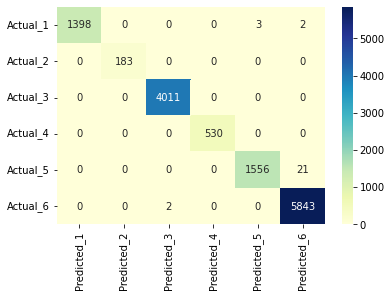

Test:


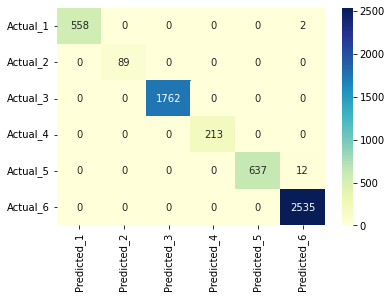

----------------------------------------


In [22]:
log_reg = LogisticRegression()

y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_n_test(log_reg)

evaluate_result(y_train=y_train, y_train_pred=y_train_pred, y_train_proba=y_train_proba, y_test=y_test, y_test_pred=y_test_pred, y_test_proba=y_test_proba)

In [23]:
log_loss(y_train, y_train_proba)

0.015153718640221574

Using the default hyperparameters of a Logistics Regression, the model did not converge even though it has an accuracy score of over 99%. We could increase the number of iterations to make the model converge. It is noteworthy that despite the non-convergence, the model has a pretty good performance. It is reflective of the fact that there could be clear linear boundaries that separate the classes in the data.

accuracy_score for Train is: 0.9979334268211676
accuracy_score for Test is: 0.9975895316804407
----------------------------------------
cohen_kappa_score for Train is: 0.9970467271670912
cohen_kappa_score for Test is: 0.9965232445168369
----------------------------------------
Train:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1403
           2       1.00      1.00      1.00       183
           3       1.00      1.00      1.00      4011
           4       1.00      1.00      1.00       530
           5       1.00      0.99      0.99      1577
           6       1.00      1.00      1.00      5845

    accuracy                           1.00     13549
   macro avg       1.00      1.00      1.00     13549
weighted avg       1.00      1.00      1.00     13549

Test:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       560
           2       1.00      1.00      1.00        89
   

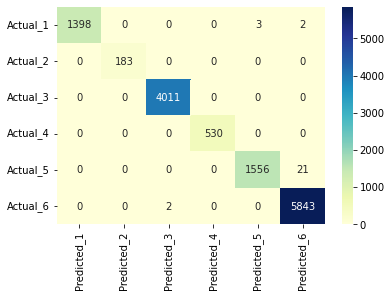

Test:


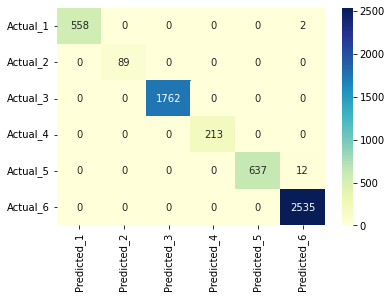

----------------------------------------


In [24]:
# Using maximum iteration of 300
log_reg2 = LogisticRegression(max_iter=300)

y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_n_test(log_reg2)

evaluate_result(y_train=y_train, y_train_pred=y_train_pred, y_train_proba=y_train_proba, y_test=y_test, y_test_pred=y_test_pred, y_test_proba=y_test_proba)

In [25]:
log_loss(y_train, y_train_proba)

0.01509259611192972

In [26]:
y_test_proba

array([[4.85687867e-08, 2.12165519e-07, 9.40547866e-06, 2.46592534e-08,
        1.94687344e-05, 9.99970840e-01],
       [5.48866739e-10, 2.05833583e-08, 1.53546118e-05, 3.92265818e-10,
        1.80586770e-05, 9.99966565e-01],
       [7.11497465e-18, 1.35683247e-16, 9.98055791e-01, 1.01662455e-16,
        3.94529216e-15, 1.94420891e-03],
       ...,
       [6.68078431e-18, 1.26045770e-16, 9.98663463e-01, 9.00771132e-17,
        3.54856860e-15, 1.33653740e-03],
       [2.15863242e-07, 3.48706719e-06, 9.92007744e-08, 2.94214548e-08,
        1.28244548e-02, 9.87171714e-01],
       [2.07360836e-05, 9.47596709e-05, 2.82056683e-13, 3.34849007e-07,
        9.88113587e-01, 1.17705826e-02]])

In [29]:
print (log_reg2.coef_)

[[ 6.86913653e-01  4.57611818e-02 -3.90781732e-01 -4.83632503e-01
  -5.56690983e-01 -4.62789688e-01 -4.35664111e-01 -3.57394679e-01
  -2.73547934e-01 -1.04929663e-01  1.15008220e-01  3.59746075e-01
   5.70130758e-01  6.39300380e-01  5.14236837e-01  5.45186424e-01
   6.14908042e-01  7.87328899e-01  1.02527193e+00  1.19073388e+00
   1.09707222e+00  9.57052619e-01  6.21367694e-01  5.91469743e-01
   6.51651301e-01  7.15991362e-01  5.49716741e-01  6.94742203e-01
   7.56723359e-01  7.52136524e-01  7.93848948e-01  9.49011940e-01
   4.81584293e-01  1.12683227e-02  1.18845578e-01 -5.46711237e-02
  -2.34560481e-01 -4.12508002e-01 -3.46871112e-01 -1.10659395e-01
  -2.32375751e-01 -2.47428981e-01 -2.42383395e-01 -2.30724875e-01
  -2.35278244e-01 -1.64946288e-01 -1.30757471e-01 -7.11530125e-02
  -4.38697580e-02 -1.73373522e-02 -2.62682623e-02 -7.76132369e-03
  -3.47918798e-02 -1.29687923e-02  5.09224270e-03  7.40298251e-02
   1.04350094e-01  1.13363921e+00  7.67718671e-01  6.92532376e-01
   4.26341

When max iter of 300 was used, the model did converge with an accuracy score of over 99%. This is indicative of the fact that the data is linearly separable. Also, the model with increased iteration saw a further decrease in the loss function which is the cross entropy loss. The low cross entropy loss function is an indication of accurate classification by the model. This shows that the converged Logistic regression model reduced the error further than the uncoverged one. Since there was no corresonding increase in the model's accuracy, it shows that the new hyperplane from the converged model did not really correct some misclassification of the uncoverged model instead, the new hyperplane was postioned such that the points are farther from it. Also with cohen kappa scores of greater than 99% it shows that the classifier is in almost perfect agreement with the data.

K Nearest Neighbours (KNN)

accuracy_score for Train is: 0.9982286515610008
accuracy_score for Test is: 0.9974173553719008
----------------------------------------
cohen_kappa_score for Train is: 0.9974687930208508
cohen_kappa_score for Test is: 0.9962745902380666
----------------------------------------
Train:
              precision    recall  f1-score   support

           1       1.00      0.99      1.00      1403
           2       1.00      1.00      1.00       183
           3       1.00      1.00      1.00      4011
           4       1.00      1.00      1.00       530
           5       1.00      0.99      0.99      1577
           6       1.00      1.00      1.00      5845

    accuracy                           1.00     13549
   macro avg       1.00      1.00      1.00     13549
weighted avg       1.00      1.00      1.00     13549

Test:
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       560
           2       1.00      1.00      1.00        89
   

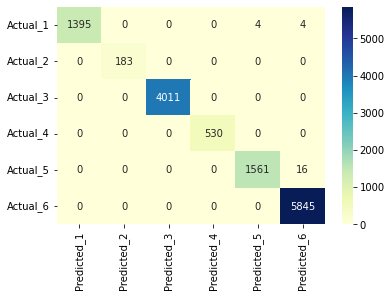

Test:


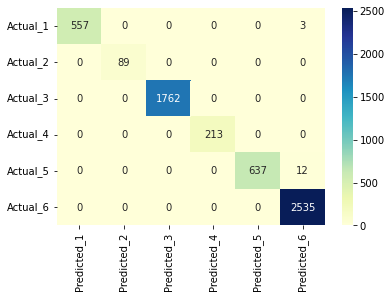

----------------------------------------


In [ ]:
knn = KNeighborsClassifier(n_neighbors=10) # k = 10, try different values

y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_n_test(knn)

evaluate_result(y_train=y_train, y_train_pred=y_train_pred, y_train_proba=y_train_proba, y_test=y_test, y_test_pred=y_test_pred, y_test_proba=y_test_proba)

For KNN, the training accuracy increased compared that of Logistics Regression. This shows that 10 nearest neighbors was able to correct some missclassification if the Logistic Regression model. As seen in the confusion matrix of the training set, the missclassification of class 5 was decreased from 21 to 16 when using KNN model. However, Logistic regression performed slightly better in the testing set. This shows that a linear hyperplane model slightly generalize well than a cluster based model for the data.

accuracy_score for Train is: 0.9985238763008341
accuracy_score for Test is: 0.9977617079889807
----------------------------------------
cohen_kappa_score for Train is: 0.9978909253987048
cohen_kappa_score for Test is: 0.9967724545858191
----------------------------------------
Train:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1403
           2       0.99      1.00      0.99       183
           3       1.00      1.00      1.00      4011
           4       1.00      1.00      1.00       530
           5       1.00      0.99      0.99      1577
           6       1.00      1.00      1.00      5845

    accuracy                           1.00     13549
   macro avg       1.00      1.00      1.00     13549
weighted avg       1.00      1.00      1.00     13549

Test:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       560
           2       0.99      1.00      0.99        89
   

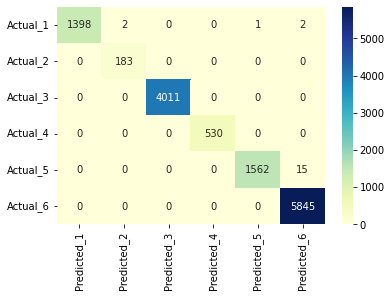

Test:


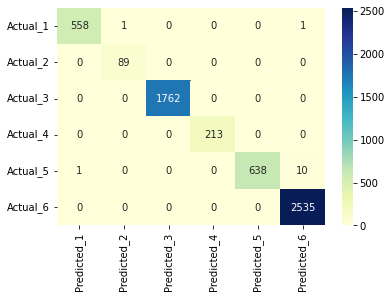

----------------------------------------


In [ ]:
dtc = DecisionTreeClassifier(max_depth=5, random_state=42) # try different parameters, include min_samples_leaf=5

y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_n_test(dtc)

evaluate_result(y_train=y_train, y_train_pred=y_train_pred, y_train_proba=y_train_proba, y_test=y_test, y_test_pred=y_test_pred, y_test_proba=y_test_proba)

In [ ]:
pd.Series(dtc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

Band_49    0.426745
Band_34    0.317670
Band_29    0.140668
Band_15    0.075373
Band_18    0.033826
             ...   
Band_28    0.000000
Band_30    0.000000
Band_31    0.000000
Band_2     0.000000
Band_63    0.000000
Length: 63, dtype: float64

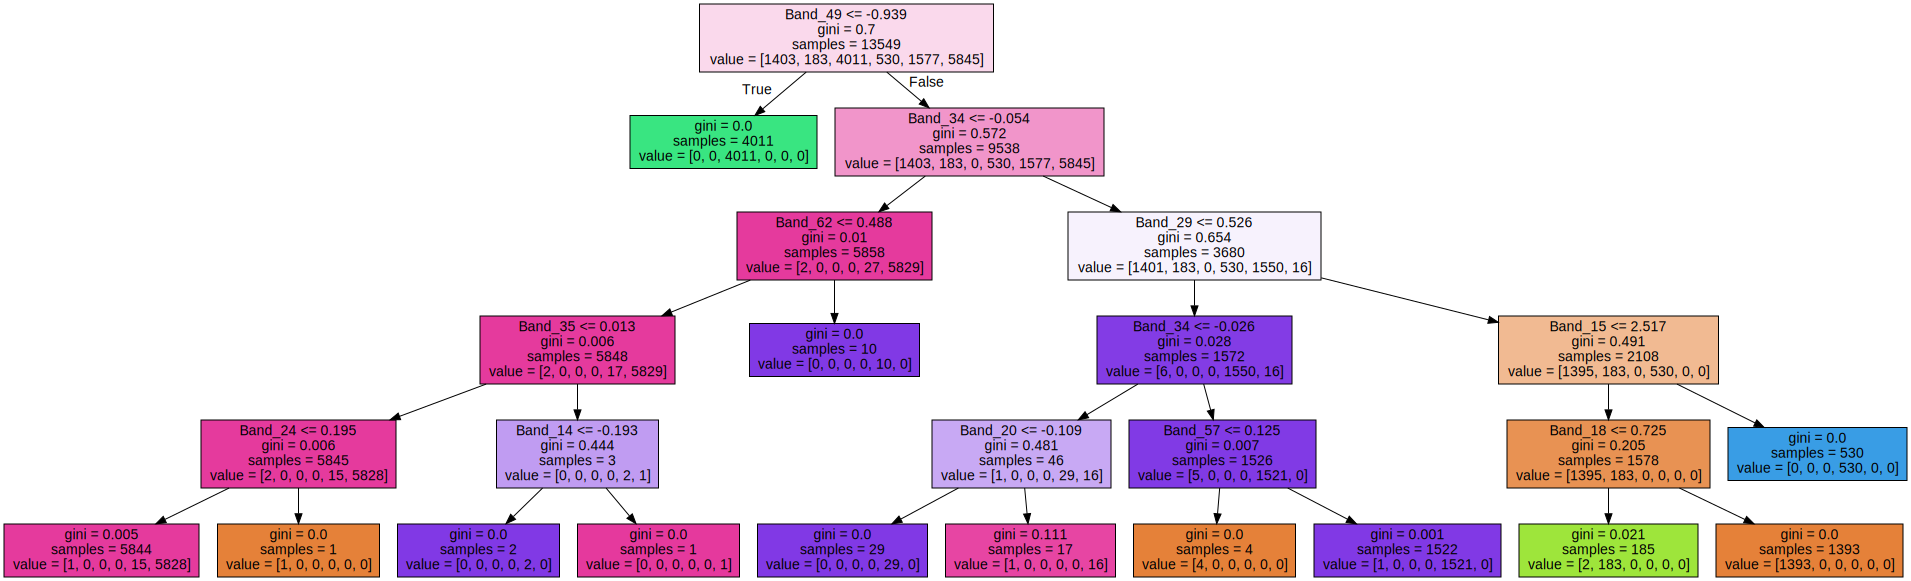

In [ ]:
# export the tree structure
tree_str = export_graphviz(dtc, feature_names=X_train.columns, 
                                     filled=True, out_file=None)

# Draw graph
graph1 = graphviz.Source(tree_str, format="png") 
graph1.render("graph1") # save the graph, check your folder
graph1

For the Decision Tree model, the model's misclassification of class 1 and 5 reduced further when compared to KNN and Logistics Regression. Also, the feature_importances_ attribute of the decision tree shows that band 49 has the most feature.This is because it was used to separate the data at the top of the tree, and that also resulted in a reduction in the gini impurity.

accuracy_score for Train is: 1.0
accuracy_score for Test is: 0.9987947658402204
----------------------------------------
cohen_kappa_score for Train is: 1.0
cohen_kappa_score for Test is: 0.9982626096162523
----------------------------------------
Train:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1403
           2       1.00      1.00      1.00       183
           3       1.00      1.00      1.00      4011
           4       1.00      1.00      1.00       530
           5       1.00      1.00      1.00      1577
           6       1.00      1.00      1.00      5845

    accuracy                           1.00     13549
   macro avg       1.00      1.00      1.00     13549
weighted avg       1.00      1.00      1.00     13549

Test:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       560
           2       1.00      1.00      1.00        89
           3       1.00      1.00

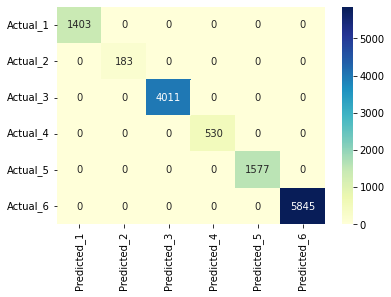

Test:


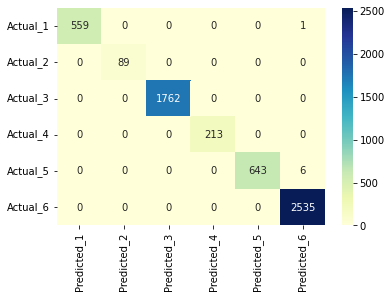

----------------------------------------


In [ ]:
rand_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1,  random_state=42) # 100 decision trees

y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_n_test(rand_forest)

evaluate_result(y_train=y_train, y_train_pred=y_train_pred, y_train_proba=y_train_proba, y_test=y_test, y_test_pred=y_test_pred, y_test_proba=y_test_proba)

Random Forest was able to perfectly learn the classification of the classes in the training set without any single misclassificaion. A total of 7 misclassification were observed which are 1 misclassification of class 1 and 6 misclassification of class 5. Random Forest seems to be robust in classifiying the data with less overfitting because it used a forest of 100 decision trees to learn the classification of the image into its classes.

accuracy_score for Train is: 0.9417669200679016
accuracy_score for Test is: 0.9447314049586777
----------------------------------------
cohen_kappa_score for Train is: 0.9185731857449739
cohen_kappa_score for Test is: 0.9219690357741113
----------------------------------------
Train:
              precision    recall  f1-score   support

           1       0.99      0.95      0.97      1403
           2       0.67      1.00      0.80       183
           3       1.00      1.00      1.00      4011
           4       1.00      0.98      0.99       530
           5       0.70      0.96      0.81      1577
           6       0.99      0.89      0.94      5845

    accuracy                           0.94     13549
   macro avg       0.89      0.96      0.92     13549
weighted avg       0.96      0.94      0.95     13549

Test:
              precision    recall  f1-score   support

           1       0.99      0.94      0.96       560
           2       0.68      1.00      0.81        89
   

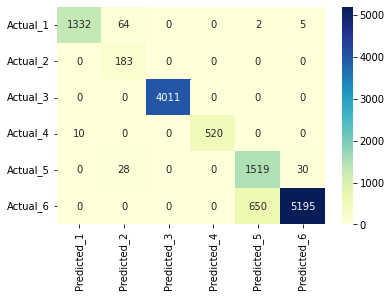

Test:


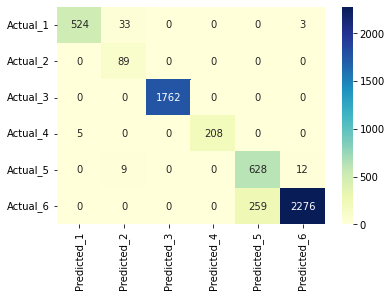

----------------------------------------


In [ ]:
gnb = GaussianNB()

y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_n_test(gnb)

evaluate_result(y_train=y_train, y_train_pred=y_train_pred, y_train_proba=y_train_proba, y_test=y_test, y_test_pred=y_test_pred, y_test_proba=y_test_proba)

Naive based model performed poorly relative to the other models. This could be because of its simplicity in using posterior probabilities in modeling the data. Most of the misclassification were due to misclassifying class 6 (wetland) as 5 (grass). Relative to the other models used, Naive Bayes model has a higher bias.

accuracy_score for Train is: 0.998745294855709
accuracy_score for Test is: 0.9984504132231405
----------------------------------------
cohen_kappa_score for Train is: 0.9982072573988838
cohen_kappa_score for Test is: 0.9977658607347203
----------------------------------------
Train:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1403
           2       1.00      1.00      1.00       183
           3       1.00      1.00      1.00      4011
           4       1.00      1.00      1.00       530
           5       1.00      0.99      0.99      1577
           6       1.00      1.00      1.00      5845

    accuracy                           1.00     13549
   macro avg       1.00      1.00      1.00     13549
weighted avg       1.00      1.00      1.00     13549

Test:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       560
           2       1.00      1.00      1.00        89
    

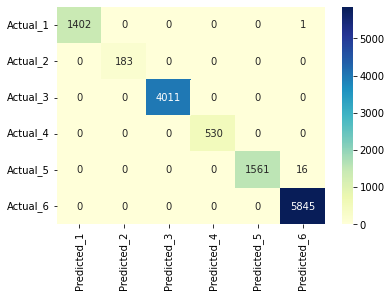

Test:


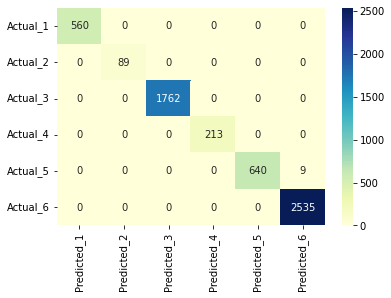

----------------------------------------


In [ ]:
linear_svc = SVC(kernel='linear', C=1.0, probability=True) 

y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_n_test(linear_svc)

evaluate_result(y_train=y_train, y_train_pred=y_train_pred, y_train_proba=y_train_proba, y_test=y_test, y_test_pred=y_test_pred, y_test_proba=y_test_proba)

Linear SVM model is less overfitted compared to linear regression and KNN as used in this data. This is because the SVM used here is soft margin that is not suceptible to outliers. The high performance of the linear SVM shows that the relaionship between the label and the feature can be represented by linear boundaries. The low variance of the model also means that it generalizes well than the previous models we have used.

accuracy_score for Train is: 0.9253081408222009
accuracy_score for Test is: 0.9264807162534435
----------------------------------------
cohen_kappa_score for Train is: 0.8897070109661649
cohen_kappa_score for Test is: 0.8903819342813879
----------------------------------------
Train:
              precision    recall  f1-score   support

           1       1.00      0.99      0.99      1403
           2       1.00      0.90      0.95       183
           3       1.00      1.00      1.00      4011
           4       1.00      1.00      1.00       530
           5       1.00      0.39      0.57      1577
           6       0.85      1.00      0.92      5845

    accuracy                           0.93     13549
   macro avg       0.97      0.88      0.90     13549
weighted avg       0.94      0.93      0.91     13549

Test:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       560
           2       1.00      0.96      0.98        89
   

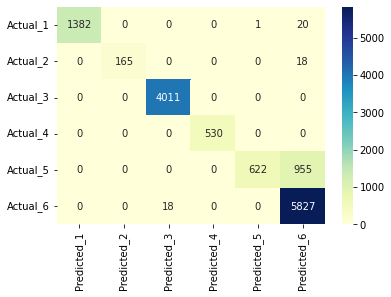

Test:


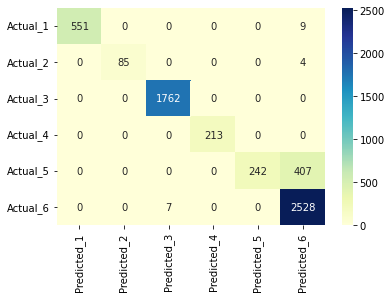

----------------------------------------


In [ ]:
poly_svc = SVC(kernel='poly', C=1.0, probability=True) 

y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_n_test(poly_svc)

evaluate_result(y_train=y_train, y_train_pred=y_train_pred, y_train_proba=y_train_proba, y_test=y_test, y_test_pred=y_test_pred, y_test_proba=y_test_proba)

The low performance of poly SVM shows that the relationship between the labels and the features are better represented by linear margins compared to non-linear (e.g. poly). The misclassifcation of class 5 as class 6 also increased for this model. This means that adding non-linearity to the model would result in misclassying Grass as Wetland.:

accuracy_score for Train is: 0.8827957782862204
accuracy_score for Test is: 0.8899793388429752
----------------------------------------
cohen_kappa_score for Train is: 0.8320872345499064
cohen_kappa_score for Test is: 0.8409086417839436
----------------------------------------
Train:
              precision    recall  f1-score   support

           1       0.75      0.59      0.66      1403
           2       1.00      0.06      0.11       183
           3       1.00      1.00      1.00      4011
           4       0.05      0.08      0.06       530
           5       0.73      0.79      0.76      1577
           6       0.98      1.00      0.99      5845

    accuracy                           0.88     13549
   macro avg       0.75      0.59      0.60     13549
weighted avg       0.90      0.88      0.88     13549

Test:
              precision    recall  f1-score   support

           1       0.72      0.58      0.65       560
           2       1.00      0.06      0.11        89
   

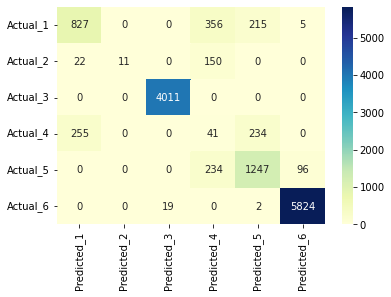

Test:


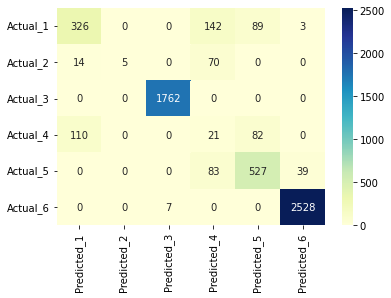

----------------------------------------


In [ ]:
sigmoid_svc = SVC(kernel='sigmoid', C=1.0, probability=True) 

y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_n_test(sigmoid_svc)

evaluate_result(y_train=y_train, y_train_pred=y_train_pred, y_train_proba=y_train_proba, y_test=y_test, y_test_pred=y_test_pred, y_test_proba=y_test_proba)

As expected, there is a low performance of sigmoid SVM in the data.This shows that the relationship between the labels and the features are better represented by linear margins compared to non-linear (e.g. sigmoid). The misclassifcation of class 1, 4, and 5 also increased for this model. This means that adding non-linearity to the model would result in more misclassification.


accuracy_score for Train is: 0.9985976824857923
accuracy_score for Test is: 0.9981060606060606
----------------------------------------
cohen_kappa_score for Train is: 0.9979962106632843
cohen_kappa_score for Test is: 0.9972689450479495
----------------------------------------
Train:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1403
           2       1.00      1.00      1.00       183
           3       1.00      1.00      1.00      4011
           4       1.00      1.00      1.00       530
           5       1.00      0.99      0.99      1577
           6       1.00      1.00      1.00      5845

    accuracy                           1.00     13549
   macro avg       1.00      1.00      1.00     13549
weighted avg       1.00      1.00      1.00     13549

Test:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       560
           2       1.00      1.00      1.00        89
   

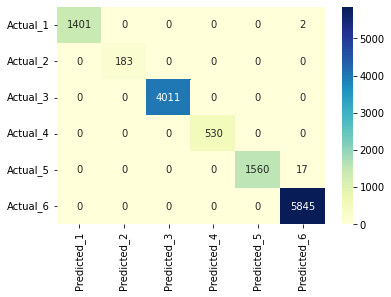

Test:


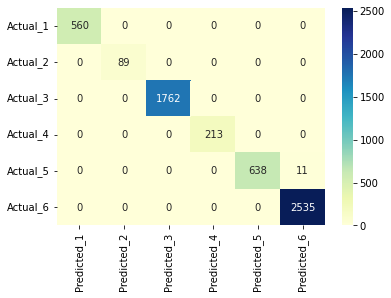

----------------------------------------


In [ ]:
rbf_svc = SVC(kernel='rbf', C=10.0, probability=True) 

y_train_pred, y_test_pred, y_train_proba, y_test_proba = train_n_test(rbf_svc)

evaluate_result(y_train=y_train, y_train_pred=y_train_pred, y_train_proba=y_train_proba, y_test=y_test, y_test_pred=y_test_pred, y_test_proba=y_test_proba)

Using RBF kernel resulted in a better performance than poly and sigmoid kernels. This shows that rbf kernel which projects the data to an infinite dimensional space was able to better separate the data into its classes.

Hyperparameter Tuning

In [ ]:
stratified_cv = StratifiedKFold(5, random_state=0, shuffle=True)

In [ ]:
kappa_scorer = make_scorer(cohen_kappa_score)

In [ ]:
knn_params = {'n_neighbors': np.arange(2, 16)}

knn = KNeighborsClassifier() 

knn_grid = GridSearchCV(estimator=knn, param_grid=knn_params, scoring=kappa_scorer, cv=stratified_cv,n_jobs=-1, return_train_score=True, refit=True,
                        verbose=True, error_score='raise')

knn_grid.fit(X, y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score='raise', estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])},
             return_train_score=True, scoring=make_scorer(cohen_kappa_score),
             verbose=True)

In [ ]:
knn_cv_results = pd.DataFrame(knn_grid.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
knn_cv_results['k'] = knn_cv_results['params'].apply(lambda x: int(x['n_neighbors']))
knn_cv_results.set_index('params')
knn_cv_results.sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,k
0,{'n_neighbors': 2},0.999926,0.998520,2
1,{'n_neighbors': 3},0.998557,0.997705,3
2,{'n_neighbors': 4},0.998650,0.997705,4
4,{'n_neighbors': 6},0.997965,0.997187,6
3,{'n_neighbors': 5},0.997909,0.997113,5
6,{'n_neighbors': 8},0.997446,0.996891,8
8,{'n_neighbors': 10},0.997132,0.996594,10
5,{'n_neighbors': 7},0.997354,0.996520,7
7,{'n_neighbors': 9},0.996983,0.996446,9
10,{'n_neighbors': 12},0.996817,0.996223,12


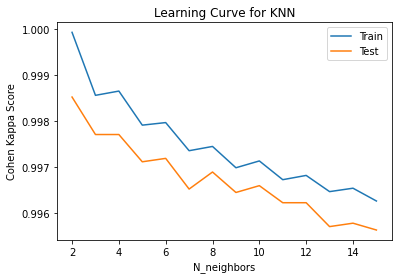

In [ ]:
plt.plot(knn_cv_results['k'], knn_cv_results['mean_train_score'], label='Train')
plt.plot(knn_cv_results['k'], knn_cv_results['mean_test_score'], label='Test')
plt.legend()
plt.xlabel('N_neighbors')
plt.ylabel('Cohen Kappa Score')
plt.title('Learning Curve for KNN')
plt.show()

In [ ]:
dtc_params = {'max_depth': np.arange(3, 10, 3), 'min_samples_leaf': np.arange(3, 10, 3)}

dtc = DecisionTreeClassifier(random_state=42)

dtc_grid = GridSearchCV(estimator=dtc, param_grid=dtc_params, scoring=kappa_scorer, cv=stratified_cv,n_jobs=-1, return_train_score=True, refit=True,
                        verbose=True, error_score='raise')

dtc_grid.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score='raise',
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([3, 6, 9]),
                         'min_samples_leaf': array([3, 6, 9])},
             return_train_score=True, scoring=make_scorer(cohen_kappa_score),
             verbose=True)

In [ ]:
dtc_cv_results = pd.DataFrame(dtc_grid.cv_results_).set_index('params')[['mean_train_score', 'mean_test_score']]
dtc_cv_results.sort_values(by='mean_test_score', ascending=False)

,mean_train_score,mean_test_score
params,,
"{'max_depth': 9, 'min_samples_leaf': 3}",0.998539,0.996596
"{'max_depth': 6, 'min_samples_leaf': 3}",0.997835,0.996373
"{'max_depth': 9, 'min_samples_leaf': 6}",0.997688,0.995856
"{'max_depth': 6, 'min_samples_leaf': 6}",0.997114,0.995633
"{'max_depth': 6, 'min_samples_leaf': 9}",0.996799,0.995485
"{'max_depth': 9, 'min_samples_leaf': 9}",0.997151,0.995411
"{'max_depth': 3, 'min_samples_leaf': 9}",0.920309,0.919826
"{'max_depth': 3, 'min_samples_leaf': 3}",0.920345,0.919822
"{'max_depth': 3, 'min_samples_leaf': 6}",0.920345,0.919822


Best Models

In [ ]:
def plot_true_and_predicted_img(model_dict, X_test, img_size, n_features=63, bands_index=[0, 1, 2], **kwargs):
    if 'figsize' in kwargs:
        fig = plt.figure(kwargs['figsize'])
    else:
        fig = plt.figure()

    test_img = X_test.reshape(tuple(list(img_size[:2])+[n_features]))[:, :, bands_index]

    for k, i in zip(model_dict.keys(), range(1, len(model_dict)+2, 2)):
        pred = model_dict[k].predict(X_test)
        pred_img = pred.reshape(img_size[:2])

        ax = fig.add_subplot(len(model_dict), 2, i)
        io.imshow(test_img)
        plt.title('Original')

        ax = fig.add_subplot(len(model_dict), 2, i+1)
        io.imshow(pred_img) 
        plt.title(k+'_Prediction')

    plt.show()

In [ ]:
model_dict = {'KNN': knn_grid, 'dtc_grid': dtc_grid}

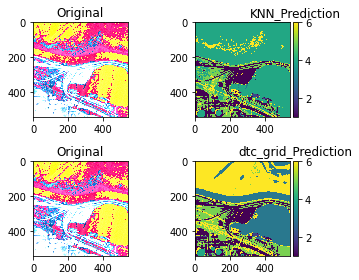

In [ ]:
import warnings
warnings.filterwarnings('ignore')

plot_true_and_predicted_img(model_dict, img_as_array, (544, 544))

The above is the plot of the original image and the KNN and Decision Tree classification results. Certain features of the image where highlighted more using decision trees more than KNN this can be as a result of overfitting by the decision tree.

Conclusion

In conclusion, most of the classifiers performed good on this data, this could be because the training data combination of the different bands per class are very distinct and linear. The models also had high recall, precision and f1-score as well as high cohen kappa train and test scores which is indicative of a clear and definite decision boundary existing that distinguishes data belonging to various classes. A few consistent misclassifications where observed especially in classes 1, 5 and 6 across the models,this could be because these classes share similar pixel values thereby causing non-linearity or multicollinearity. Also it could be because class 6 and 1 are some of the two biggest classes in the data and the classifier could get a lot of its predictions right just by guessing one of those two classes over and over. In minimizing this missclassification it was observed that the random forest classifier performed best, this is most likely because of the decorrelation property of random forest. 